### Outage Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import math
import matplotlib.dates as mdates

import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, mapping
import plotly.figure_factory as ff
import fiona
import matplotlib.pyplot as plt
import contextily as ctx
from IPython.display import clear_output
from fiona.crs import from_epsg

In [2]:
database = "./data_from_AWS/test_2_16Oct20.db"
connection = sqlite3.connect(database)

df_main = pd.read_sql('SELECT * FROM test_3', con = connection)

In [3]:
df_main['StartDate_c'] = df_main['StartDate'].apply(lambda x: datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
df_main['EstimatedRestoreDate_c'] = df_main['EstimatedRestoreDate'].apply(lambda x: datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S') if str(x) != 'nan' else np.nan)

In [4]:
df_main_no_dup = df_main.drop_duplicates(subset=['OBJECTID', 'IncidentId'])

In [5]:
result_dict = {}

for utility in df_main['UtilityCompany'].unique():
    sub_result_dict = {}
    for time in df_main['time'].unique():
        sub_result_dict[time] = df_main[(df_main['time']==time) &
                                    (df_main['UtilityCompany']==utility)
                                   ]['ImpactedCustomers'].sum()
    result_dict[utility]=sub_result_dict

In [6]:
df_customers_out = pd.DataFrame(result_dict)

In [7]:
df_customers_out['Datetime'] = df_customers_out.index
df_customers_out['Datetime'] = df_customers_out['Datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))

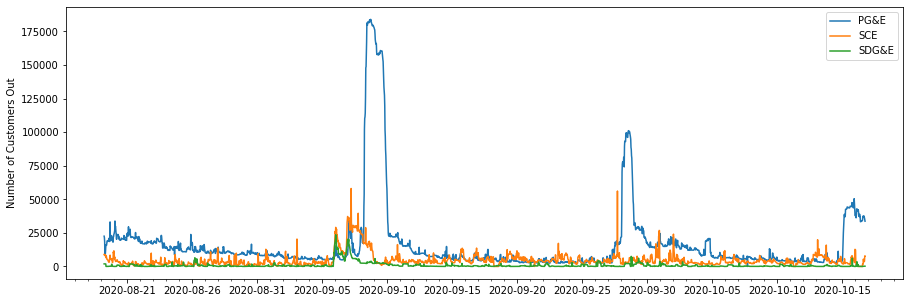

In [9]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,1,1)  

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(df_customers_out['Datetime'].values, df_customers_out['PGE'].values, label='PG&E')
ax.plot(df_customers_out['Datetime'].values, df_customers_out['SCE'].values, label='SCE')
ax.plot(df_customers_out['Datetime'].values, df_customers_out['SDGE'].values, label='SDG&E')

ax.set_ylabel('Number of Customers Out')
plt.legend()
plt.show()

### Shapefile Analysis

In [2]:
database = './data_from_AWS/outage_shapefile_16Oct20_2.db'
connection = sqlite3.connect(database)

df_shape = pd.read_sql('SELECT * FROM test_10', con = connection)

In [5]:
list(df_shape['time'].unique())

['2020-09-08 13:42',
 '2020-09-08 14:00',
 '2020-09-08 14:30',
 '2020-09-08 15:00',
 '2020-09-08 15:30',
 '2020-09-08 16:00',
 '2020-09-08 16:30',
 '2020-09-08 17:00',
 '2020-09-08 17:30',
 '2020-09-08 18:00',
 '2020-09-08 18:30',
 '2020-09-08 19:00',
 '2020-09-08 19:30',
 '2020-09-08 20:00',
 '2020-09-08 20:30',
 '2020-09-08 21:00',
 '2020-09-08 21:30',
 '2020-09-08 22:00',
 '2020-09-08 22:30',
 '2020-09-08 23:00',
 '2020-09-08 23:30',
 '2020-09-09 00:00',
 '2020-09-09 00:30',
 '2020-09-09 01:00',
 '2020-09-09 01:30',
 '2020-09-09 02:00',
 '2020-09-09 02:30',
 '2020-09-09 03:00',
 '2020-09-09 03:30',
 '2020-09-09 04:00',
 '2020-09-09 04:30',
 '2020-09-09 05:00',
 '2020-09-09 05:30',
 '2020-09-09 06:00',
 '2020-09-09 06:30',
 '2020-09-09 07:00',
 '2020-09-09 07:30',
 '2020-09-09 08:00',
 '2020-09-09 08:30',
 '2020-09-09 09:00',
 '2020-09-09 09:30',
 '2020-09-09 10:00',
 '2020-09-09 10:30',
 '2020-09-09 11:00',
 '2020-09-09 11:30',
 '2020-09-09 12:00',
 '2020-09-09 12:30',
 '2020-09-09 

In [9]:
df_shape_latest = df_shape[df_shape['time'] == '2020-09-28 12:00']
df_shape_latest['rings_converted'] = df_shape_latest['rings'].apply(lambda x: json.loads(x)[0])
df_shape_latest = df_shape_latest.reset_index()
dict_shape = df_shape_latest.to_dict()

In [10]:
polygon_list = []

for i in range(0, len(df_shape_latest['rings_converted'])):
    polygon_list.append(Polygon(df_shape_latest['rings_converted'][i]))
    i+=1

#### Write Shape Files

In [11]:
schema = {
    'geometry': 'Polygon',
    'properties': {'OBJECTID': 'int',
                   'UtilityCompany':'str',
                   'StartDate': 'int',
                   'EstimatedRestoreDate': 'int',
                   'Cause': 'str',
                   'ImpactedCustomers': 'int',
                   'Shape__Area': 'float',
                   'Shape__Length': 'float',
                   'County': 'str',
                   'OutageStatus': 'str',
                   'OutageType': 'str',
                   'IncidentId': 'int'
                  },
}

with fiona.open('./shapefiles/my_shp_28Sep20.shp', 'w', crs=from_epsg(4326), driver='ESRI Shapefile', schema=schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    
    for i in range(0, df_shape_latest.shape[0]):    
        c.write({
            'geometry': mapping(polygon_list[i]),
            'properties': {'OBJECTID': dict_shape['OBJECTID'][i],
                           'UtilityCompany': dict_shape['UtilityCompany'][i],
                           'StartDate': dict_shape['StartDate'][i],
                           'EstimatedRestoreDate': dict_shape['EstimatedRestoreDate'][i],
                           'Cause': dict_shape['Cause'][i],
                           'ImpactedCustomers': dict_shape['ImpactedCustomers'][i],
                           'Shape__Area': dict_shape['Shape__Area'][i],
                           'Shape__Length': dict_shape['Shape__Length'][i],
                           'County': dict_shape['County'][i],
                           'OutageStatus': dict_shape['OutageStatus'][i],
                           'OutageType': dict_shape['OutageType'][i],
                           'IncidentId': dict_shape['IncidentId'][i]        
                          },
        })

In [17]:
mergedpoly = polygon_list[0]

for i in range(1, len(polygon_list)):
    mergedpoly = mergedpoly.union(polygon_list[i])

In [18]:
df_all_CA = pd.read_excel('./all_CA_properties.xlsx')

In [19]:
ca_points = []

for i in range(0, df_all_CA.shape[0]):
    ca_points.append({df_all_CA['Costar_Property_ID'][i] : Point(df_all_CA['Longitude'][i], df_all_CA['Latitude'][i])})
    print(i)
    clear_output(wait=True)

41164


In [20]:
affected_list = []

for i in range(0, df_all_CA.shape[0]):
    (k, v), = ca_points[i].items()
    if mergedpoly.contains(v):
        affected_list.append(k)
        print("hit")
    i+=1
    print(i)
    clear_output(wait=True)

40995


In [21]:
affected_list

[8369026,
 8019640,
 1000000279,
 1000000343,
 1160721,
 10784635,
 10087404,
 10162486,
 8045745,
 8045751,
 336240,
 346557,
 9269097,
 9908934,
 9506803,
 9436560,
 9460643,
 9490401,
 9581963,
 8938324,
 10329046,
 597401,
 6035583,
 304024,
 42580,
 4542137,
 8965343,
 9124823,
 307702,
 307453,
 311540,
 51280,
 7564178,
 4335371,
 4508592,
 10796008,
 1184829,
 5569479,
 5743520,
 5673099,
 6670841,
 310665,
 10139298,
 7065346,
 7065351,
 1413453,
 8841072]